In [1]:
from dlcutils import Config, fold_connectome
import networkx as nx
import matplotlib.pyplot as plt

In [178]:
import random

    
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, scale_by_last_layer: bool = True):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    # if not nx.is_tree(G):
    #     raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    if scale_by_last_layer:
        new_pos = {}
        # Get all the x coordinates of the nodes in the last layer
        i = 0
        last_layer_pos = {}
        for node in pos:
            if len(list(G.neighbors(node))) == 0:
                new_pos[node] = (i, pos[node][1])
                last_layer_pos[node] = pos[node][0]
                i += 1
        
        # Partition all nodes into groups based upon the last-layer nodes to
        # their left and right:
        last_layer_pos = sorted(last_layer_pos.items(), key=lambda x: x[1])

        for node, pos in pos.items():
            if node in new_pos:
                continue
            for llni, (lln, llx) in enumerate(last_layer_pos):
                if llx > pos[0]:
                    new_pos[node] = (llni, pos[1])
                    break
            else:
                new_pos[node] = (i, pos[1])
                i += 1

        for k, v in new_pos.items():
            if k.lower() in con_nodes_lower:
                new_pos[k] = (v[0], -2.7)
        return new_pos, [i for i, j in last_layer_pos]
            
    return pos

In [179]:
con = fold_connectome(Config.get_connectome())
lin = Config.get_lineage_graph()
print(len(lin))

1756


In [180]:
# Set intersect of nodes in lineage graph and connectome graph:
nodes = set(con.nodes()).intersection(set(lin.nodes()))
con = con.subgraph(nodes)

In [181]:
# Get all ancestors of `nodes` in lineage graph:
ancestors = set()
for node in nodes:
    ancestors.update(nx.ancestors(lin, node))
lin_ancestors = lin.subgraph(ancestors.union(nodes))

In [182]:
con_nodes_lower = [
    node.lower() for node in con.nodes()
]

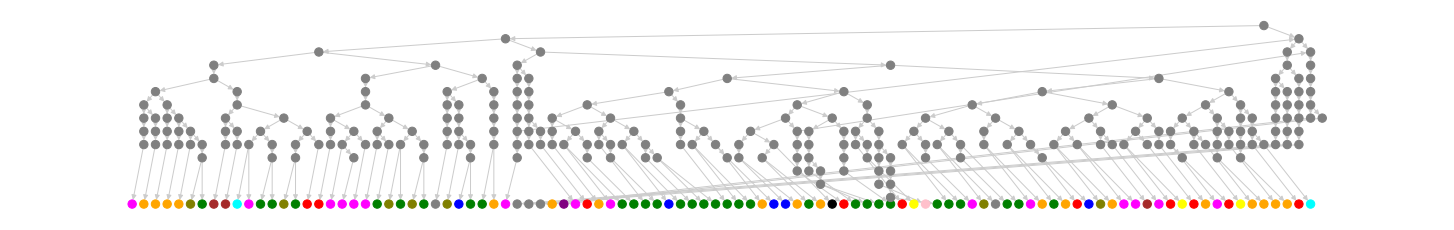

In [183]:
def colorize(typ):
    typs = list(set([n['typ'] for _, n in con.nodes(data=True)]))
    return [
        "red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan", "magenta", "yellow", "black", "white"
    ][typs.index(typ)]
pos, order = hierarchy_pos(lin_ancestors, scale_by_last_layer=True)
plt.figure(figsize=(20, 3))
nx.draw(
    lin_ancestors, 
    pos=pos,
    node_size=70,
    
    # Color nodes grey unless they're in the connectome:
    node_color=[
        # '#babeee' if node.lower() in con_nodes_lower else 'grey'
        colorize(con.nodes[n]['typ']) if n in con.nodes else 'grey'
        for n in lin_ancestors.nodes()
    ],
    edge_color='#ccc'
)

<Figure size 504x504 with 0 Axes>

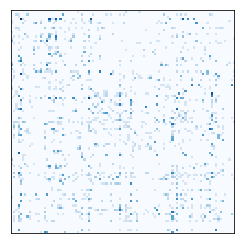

In [208]:
import numpy as np
mat = nx.adjacency_matrix(con, nodelist=order, weight='synapses')
plt.figure(figsize=(7, 7))
plt.matshow(np.log(1+mat.toarray()), cmap=plt.cm.Blues)
# no axis ticks:
plt.xticks([])
plt.yticks([])
plt.show()